In [ ]:
!uv pip install -q --system numba-cuda==0.4.0
!pip install --upgrade numba

import numba
import numba.cuda as cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import numpy as np
import math, time,cv2

Image 1: (604, 900, 3), range [0.0, 255.0]
Image 2: (604, 900, 3), range [0.0, 255.0]


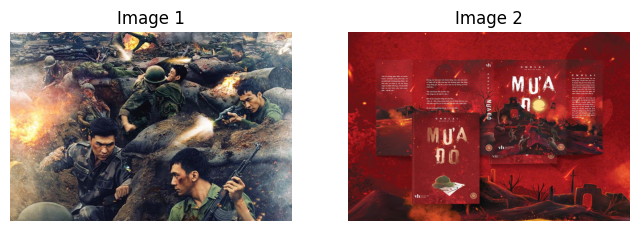

In [ ]:
img1 = plt.imread("/content/fl.jpg")
img2 = plt.imread("/content/fh.jpg")

if img1.max() <= 1.0: img1 *= 255.0
if img2.max() <= 1.0: img2 *= 255.0
img1 = img1.astype(np.float32)
img2 = cv2.resize(img2.astype(np.float32), (img1.shape[1], img1.shape[0]))

print(f"Image 1: {img1.shape}, range [{img1.min():.1f}, {img1.max():.1f}]")
print(f"Image 2: {img2.shape}, range [{img2.min():.1f}, {img2.max():.1f}]")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img1.astype(np.uint8))
plt.title("Image 1")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img2.astype(np.uint8))
plt.title("Image 2")
plt.axis("off")
plt.show()


6a GPU time: 0.0859s


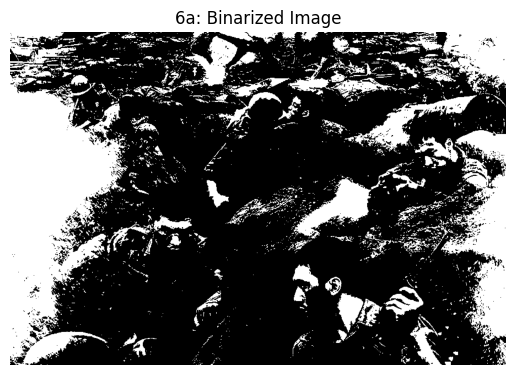

In [23]:
@cuda.jit
def grayscale_binarize_kernel(src, dst, threshold):
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if x < src.shape[0] and y < src.shape[1]:
        g = (src[x, y, 0] + src[x, y, 1] + src[x, y, 2]) / 3.0
        bin_val = 255.0 if g >= threshold else 0.0
        dst[x, y, 0] = bin_val
        dst[x, y, 1] = bin_val
        dst[x, y, 2] = bin_val

# GPU execution
d_src = cuda.to_device(img1)
d_dst = cuda.device_array_like(img1)
block = (16, 16)
grid = (math.ceil(img1.shape[0]/block[0]), math.ceil(img1.shape[1]/block[1]))

threshold = 128.0
start = time.time()
grayscale_binarize_kernel[grid, block](d_src, d_dst, threshold)
cuda.synchronize()
end = time.time()

bin_img = d_dst.copy_to_host()
print(f"6a GPU time: {end - start:.4f}s")

plt.imshow(bin_img.astype(np.uint8))
plt.title(f"6a: Binarized Image")
plt.axis("off")
plt.show()

6b GPU time: 0.1492s


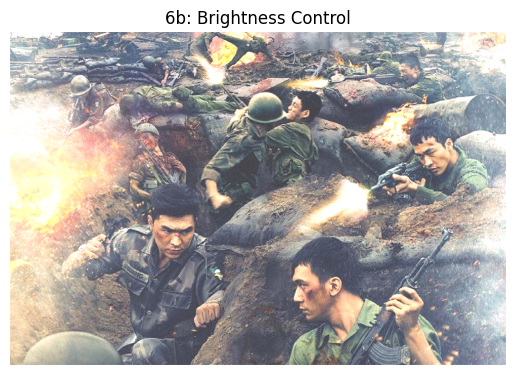

In [25]:
@cuda.jit(device=True)
def brightness_control(value, amount):
    result = value + amount
    if result > 255:
        result = 255
    elif result < 0:
        result = 0
    return result

@cuda.jit
def brightness_kernel(src, dst, amount):
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    if x < src.shape[0] and y < src.shape[1]:
        for c in range(src.shape[2]):
            dst[x, y, c] = brightness_control(src[x, y, c], amount)

d_src = cuda.to_device(img1)
d_bright = cuda.device_array_like(img1)
block = (32, 8)
grid = (math.ceil(img1.shape[0]/block[0]), math.ceil(img1.shape[1]/block[1]))

amount = 60.0
start = time.time()
brightness_kernel[grid, block](d_src, d_bright, amount)
cuda.synchronize()
end = time.time()

bright_img = d_bright.copy_to_host()
print(f"6b GPU time: {end - start:.4f}s")

plt.imshow(np.clip(bright_img, 0, 255).astype(np.uint8))
plt.title(f"6b: Brightness Control")
plt.axis("off")
plt.show()

6c GPU time (α=0.5): 0.1193s


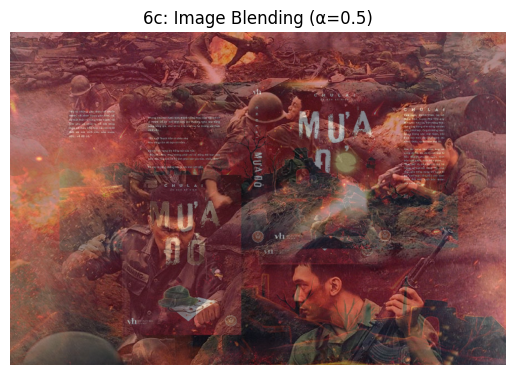

In [26]:
@cuda.jit(device=True)
def blend_pixel(val1, val2, c):
    return val1 * c + val2 * (1 - c)

@cuda.jit
def blend_images(src1, src2, dst, c):
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    if x < src1.shape[0] and y < src1.shape[1]:
        for ch in range(src1.shape[2]):
            dst[x, y, ch] = blend_pixel(src1[x, y, ch], src2[x, y, ch], c)

img1_c = np.ascontiguousarray(img1)
img2_c = np.ascontiguousarray(img2)

d_img1 = cuda.to_device(img1_c)
d_img2 = cuda.to_device(img2_c)
d_blend = cuda.device_array_like(img1_c)

block = (16, 16)
grid = (math.ceil(img1.shape[0]/block[0]), math.ceil(img1.shape[1]/block[1]))
alpha = 0.5

start = time.time()
blend_images[grid, block](d_img1, d_img2, d_blend, alpha)
cuda.synchronize()
end = time.time()

blend_img = d_blend.copy_to_host()
print(f"6c GPU time (α={alpha}): {end - start:.4f}s")

plt.imshow(np.clip(blend_img, 0, 255).astype(np.uint8))
plt.title(f"6c: Image Blending (α={alpha})")
plt.axis("off")
plt.show()